---

---

# 프로그램

## 1. 기본 라이브러리 / 함수
### 1.1. 라이브러리

In [1]:
!pip install -q albumentations
!pip install -q ultralytics
!pip install -q roboflow
!pip install -q opencv-python
!pip install -q opencv-python-headless
print("로딩완료")

로딩완료


In [2]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🌐 https://c0z0c.github.io/jupyter_hangul
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = d:\GoogleDrive\homepage\스프린트미션\스프린트미션_작업중
🌐 https://c0z0c.github.io/jupyter_hangul
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = d:\GoogleDrive\homepage\스프린트미션\스프린트미션_작업중


<module 'helper_c0z0c_dev' from 'd:\\GoogleDrive\\homepage\\스프린트미션\\스프린트미션_작업중\\helper_c0z0c_dev.py'>

In [3]:
# 기본 라이브러리

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import average_precision_score

# --- 기타 라이브러리 ---
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import albumentations as A
import IPython.display
#from tqdm import tqdm
from tqdm.notebook import tqdm

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as TF
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- 기타 ---
import re
import os
import sys
import copy
import json
import math
import random
import yaml
import shutil
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from datetime import datetime
from datetime import timezone, timedelta
import pytz
__kst = pytz.timezone('Asia/Seoul')

# GPU 설정
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

  # 재현 가능한 결과를 위해
np.random.seed(42)
torch.manual_seed(42)
if __device == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치:{__device}")

라이브러리 로드 완료 사용장치:cpu


### > 설정 < 플레그

In [4]:
# 디버그 모드 (필요시 True로 변경)
DEBUG_ON = False
if not helper.is_colab:
    DEBUG_ON = True

IMAGE_SIZE_ORG=300 # 300을 이미지의 최대 크기로 사용
IMAGE_SIZE=300 # 300을 모델의 입력 크기로 사용
BATCH_SIZE=16

__MEAN_TENSOR = [0.485, 0.456, 0.406]
__STD_TENSOR = [0.229, 0.224, 0.225]
__MEAN_RGB = [123, 116, 103]
__STD_RGB = [58, 57, 57]

def mean_std(type=None, mean_tensor=None, std_tensor=None, mean_rgb=None, std_rgb=None):
    """
    Mean (RGB): [0.485, 0.456, 0.406]
    Std (RGB):  [0.229, 0.224, 0.225]
    Mean (RGB, 0~255): [123, 116, 103]
    Std (RGB, 0~255):  [58, 57, 57]
    """
    global __MEAN_TENSOR, __STD_TENSOR, __MEAN_RGB, __STD_RGB
    res_old = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if mean_tensor is not None:
        __MEAN_TENSOR = mean_tensor
    if std_tensor is not None:
        __STD_TENSOR = std_tensor
    if mean_rgb is not None:
        __MEAN_RGB = mean_rgb
    if std_rgb is not None:
        __STD_RGB = std_rgb

    res = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if res_old != res:
        print(f"변경사항 발견: { json.dumps(res_old, indent=2, ensure_ascii=False)} -> {json.dumps(res, indent=2, ensure_ascii=False)}")

    if type is None:
        return res
    return res.get(type, res)


print(f'이미지 원본크기:{IMAGE_SIZE_ORG} 모델입력크기:{IMAGE_SIZE} DEBUG_ON:{DEBUG_ON}')
print(f'평균 표준편차 {mean_std()}')

이미지 원본크기:300 모델입력크기:300 DEBUG_ON:True
평균 표준편차 {'mean_tensor': [0.485, 0.456, 0.406], 'std_tensor': [0.229, 0.224, 0.225], 'mean_rgb': [123, 116, 103], 'std_rgb': [58, 57, 57]}


### 1.2. 유틸리티 함수

#### 1.2.1 기본 유틸리티 함수

In [5]:

def get_tqdm_kwargs_old():
    """환경에 맞는 tqdm 설정 반환"""
    if helper.is_colab or 'ipykernel' in sys.modules:
        # Jupyter/Colab 환경
        # return {'disable': False, 'leave': True, 'position': 0, 'ncols': 60}  # 폭 60으로 지정
        return {'disable': False, 'leave': True, 'position': 0}
    else:
        # 일반 Python 환경
        #return {'disable': False, 'mininterval': 1, 'leave': True, 'ncols': 60}
        return {'disable': False, 'mininterval': 1, 'leave': True}

def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    root_path = os.path.join("D:\\", "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    modeling_path = "modeling_yolo"
    if DEBUG_ON:
        modeling_path = modeling_path +"_debug"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    modeling_path = "modeling_yolo"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, list_count=3, indent=""):
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return

    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- "+ item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > list_count:
                print(indent + "   "+ f"[데이터파일: {img_count}개]")
            print_dir_tree(root=path, max_depth=max_depth-1, list_count=list_count, indent=indent + "   ")
        else:
            if list_count < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- "+ item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f" {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

def print_json_tree(data, indent="", max_depth=4, _depth=0, list_count=2, print_value=True):
    """
    JSON 객체를 지정한 단계(max_depth)까지 트리 형태로 출력
    - list 타입은 3개 이상일 때 개수만 출력
    - 하위 노드가 값일 경우 key(type) 형태로 출력
    - print_value=True일 때 key(type): 값 형태로 출력
    """
    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                print(f"{indent}|-- {key}")
                print_json_tree(value, indent + "    ", max_depth, _depth + 1, list_count, print_value)
            else:
                if print_value:
                    print(f"{indent}|-- {key}({type(value).__name__}): {value if len(str(value)) < 100 else f'{str(value)[:30]}...'}")
                else:
                    print(f"{indent}|-- {key}({type(value).__name__})")
    elif isinstance(data, list):
        if len(data) > list_count:
            print(f"{indent}|-- [list] ({len(data)} items)")
        else:
            for i, item in enumerate(data):
                if isinstance(item, (dict, list)):
                    print(f"{indent}|-- [{i}]")
                    print_json_tree(item, indent + "    ", max_depth, _depth + 1, list_count, print_value)
                else:
                    if print_value:
                        print(f"{indent}|-- [{i}]({type(item).__name__}): {item if len(str(item)) < 100 else f'{str(item)[:30]}...'}")
                    else:
                        print(f"{indent}|-- [{i}]({type(item).__name__})")
    else:
        if print_value:
            print(f"{indent}{type(data).__name__}: {data if len(str(data)) < 100 else f'{str(data)[:30]}...'}")
        else:
            print(f"{indent}{type(data).__name__}")

def print_git_tree(data, indent="", max_depth=3, _depth=0):
    """
    PyTorch tensor/딕셔너리/리스트를 git tree 스타일로 출력
    """
    import torch
    import numpy as np

    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}├─ {key} [{type(value).__name__}]")
            print_git_tree(value, indent + "│  ", max_depth, _depth + 1)
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            print(f"{indent}├─ [{i}] [{type(item).__name__}]")
            print_git_tree(item, indent + "│  ", max_depth, _depth + 1)
    elif torch.is_tensor(data):
        shape = tuple(data.shape)
        dtype = str(data.dtype)
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ Tensor shape={shape} dtype={dtype} preview={preview_str}")
    elif isinstance(data, np.ndarray):
        shape = data.shape
        dtype = data.dtype
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ ndarray shape={shape} dtype={dtype} preview={preview_str}")
    else:
        val_str = str(data)
        print(f"{indent}└─ {type(data).__name__}: {val_str[:80]}{'...' if len(val_str)>80 else ''}")


print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


## 2. 데이터 로드

### 2.1. 데이터 다운로드

In [6]:
import kagglehub

# Download latest version
kagglehub_path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")
def get_path_data():
    path = kagglehub_path
    return path

#print("Path to dataset files:", get_path_data())
#print_dir_tree(kagglehub_path, max_depth=3)


def get_pet_dataset_paths():
    """Oxford-IIIT Pet Dataset 경로 반환 (실제 xmls 경로 자동 탐색)"""
    data_path = get_path_data()
    images_path = os.path.join(data_path, "images", "images")
    annotations_path = os.path.join(data_path, "annotations", "annotations")

    # xmls 경로 후보 리스트
    xmls_candidates = [
        os.path.join(annotations_path, "xmls"),
        os.path.join(annotations_path, "annotations", "xmls"),
        os.path.join(data_path, "annotations", "xmls"),
        os.path.join(data_path, "annotations", "annotations", "xmls"),
        annotations_path,
    ]
    xmls_path = None
    for candidate in xmls_candidates:
        if os.path.exists(candidate):
            xmls_path = candidate
            break

    dataset_path = {
        "root": data_path,
        "images": images_path,
        "annotations": annotations_path,
        "xmls": xmls_path if xmls_path else "",  # 없으면 빈 문자열
    }
    return dataset_path

__dataset_path = get_pet_dataset_paths()

def data_path(key):
    return __dataset_path.get(key)

#print("Path to dataset files:", get_path_data())
#print_dir_tree(kagglehub_path, max_depth=3)
#print(json.dumps(__dataset_path, indent=2, ensure_ascii=False))
# for key in __dataset_path.keys():
#     print(f"{key} 데이터 경로: {data_path(key)}")

print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


In [7]:
def parse_list_file(file_path):
    """
    list 파일을 파싱하여 DataFrame으로 변환
    list.txt
    #Image CLASS-ID SPECIES BREED ID
    #ID: 1:37 Class ids
    #SPECIES: 1:Cat 2:Dog
    #BREED ID: 1-25:Cat 1:12:Dog
    #All images with 1st letter as captial are cat images
    #images with small first letter are dog images
    Abyssinian_100 1 1 1
    Abyssinian_101 1 1 1
    Abyssinian_102 1 1 1
    Abyssinian_103 1 1 1

    """
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) == 4:
                image_name = parts[0]
                class_id = int(parts[1])
                species_id = int(parts[2])  # 1: cat, 2: dog
                breed_id = int(parts[3])

                data.append({
                    'image_name': image_name,
                    'class_id': class_id,
                    'species_id': species_id,
                    'breed_id': breed_id,
                    'species': 'cat' if species_id == 1 else 'dog'
                })

    return pd.DataFrame(data)

def load_xmls(list_df, train_df, test_df):
    """간단하게 XML 로드하고 train/test 분할"""
    xml_dir = __dataset_path['xmls']
    records = []

    endmesg = ""
    # XML 파일들 읽기
    pbar = tqdm(list_df.iterrows(), total=len(list_df), **get_tqdm_kwargs())
    for _, row in pbar:
        image_name = row['image_name']
        xml_file = os.path.join(xml_dir, image_name + '.xml')

        pbar.set_postfix_str(endmesg)

        # 이미지와 XML 파일 경로 설정
        image_path = os.path.join(__dataset_path['images'], f"{image_name}.jpg")
        if os.path.exists(image_path) == False:
            endmesg = f"파일 없음: {image_path}"
            continue

        #  trimap 경로 수정 - 여러 패턴으로 찾기
        trimaps_dir = os.path.join(__dataset_path['annotations'], 'trimaps')
        trimaps = ""
        if os.path.exists(trimaps_dir):
            # 여러 가능한 파일명 패턴 시도
            possible_names = [
                f"{image_name}.png",           # 기본 패턴
                f"trimap_{image_name}.png",    # trimap_ 접두사
                f"{image_name}_trimap.png"    # _trimap 접미사
            ]

            for pattern in possible_names:
                trimap_path = os.path.join(trimaps_dir, pattern)
                if os.path.exists(trimap_path):
                    # 숨김 파일이 아니고 크기가 충분한 파일만 선택
                    if not pattern.startswith('._') and os.path.getsize(trimap_path) > 1000:
                        try:
                            # 실제로 이미지인지 확인
                            test_img = Image.open(trimap_path)
                            test_img.verify()
                            trimaps = trimap_path
                            break
                        except:
                            continue

        field = {
                'image_name': image_name,
                'image_path': image_path,
                'class_id': row['class_id'],
                'species_id': row['species_id'],
                'breed_id': row['breed_id'],
                'species': row['species'], # cat dog
                'trimap_path': trimaps,
                'width': None,
                'height': None,
                'xmin': None,
                'ymin': None,
                'xmax': None,
                'ymax': None,
                'object_name': None,
                'pose': None,
                'truncated': None,
                'occluded': None,
                'difficult': None,
                'augmented': 0, # 0 오리지널 1 ~ n 증강옵션에 따라
                }

        if trimaps is None or trimaps == "":
            endmesg = f"Trimap 없음: {image_name} trimaps:{trimaps}"
            continue

        if os.path.exists(xml_file):
            try:
                # XML 파싱
                tree = ET.parse(xml_file)
                root = tree.getroot()
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)

                # 바운딩 박스 정보
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    field.update({
                        'width': width,
                        'height': height,
                        'xmin': int(bbox.find('xmin').text),
                        'ymin': int(bbox.find('ymin').text),
                        'xmax': int(bbox.find('xmax').text),
                        'ymax': int(bbox.find('ymax').text),
                        'object_name': obj.find('name').text if obj.find('name') is not None else None, # cat dog
                        'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                        'truncated': int(obj.find('truncated').text) if obj.find('truncated') is not None else None,
                        'occluded': int(obj.find('occluded').text) if obj.find('occluded') is not None else None,
                        'difficult': int(obj.find('difficult').text) if obj.find('difficult') is not None else None,
                    })

                    # bbox 정보가 맞는지 검토 하자
                    if (field['xmin'] < 0 or field['ymin'] < 0 or
                        field['xmax'] > field['width'] or field['ymax'] > field['height']):
                        endmesg = f"Invalid bbox for {image_name}: {field}"
                        continue
                    if train_df['image_name'].isin([image_name]).any(): # Train 데이터에 존재
                        records.append(field.copy())
                    else:
                        endmesg = f"Train 데이터에 없음: {image_name}"

            except Exception as e:
                endmesg = print(f"Error parsing {xml_file}: {e}")
        else:
            if test_df['image_name'].isin([image_name]).any():
                records.append(field.copy())
            else:
                endmesg = f"Test 데이터에 없음: {image_name}"

    # DataFrame 생성
    df = pd.DataFrame(records)

    # 간단한 train/test 분할
    df['train'] = df['image_name'].isin(train_df['image_name'])

    print(f"총 데이터: {len(df)}/{len(list_df)}개 ({len(df)/len(list_df)*100:.1f}%)")
    valid_trimaps = (df['trimap_path'] != "").sum()
    print(f"유효한 Trimap: {valid_trimaps}/{len(df)}개 ({valid_trimaps/len(df)*100:.1f}%)")

    return df


__kind_id_species = {}
def get_species_by_kind_id(class_id):
    return __kind_id_species.get(class_id, None)

def print_kind_id():
    # class ID를 DataFrame로 하여 가로로 출력하자
    df = pd.DataFrame(__kind_id_species.items(), columns=['Kind ID', 'Species'])
    df.T.head_att()

def load_data_frame():
    global __kind_id_species

    # 파일 경로 설정
    base_path = __dataset_path['annotations']

    list_path = os.path.join(base_path, "list.txt")
    trainval_path = os.path.join(base_path, "trainval.txt")
    test_path = os.path.join(base_path, "test.txt")

    # 데이터 파싱
    list_df = parse_list_file(list_path)
    train_df = parse_list_file(trainval_path)
    test_df = parse_list_file(test_path)

    for _, row in list_df.iterrows():
        __kind_id_species[row['class_id']] = row['species']

    data_df = load_xmls(list_df, train_df, test_df)

    # 다시 데이터 분환
    train_df = data_df[data_df['train']].copy()
    test_df = data_df[~data_df['train']].copy()
    train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42)

    return train_df, valid_df, test_df

print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


In [8]:
# yolo_dataset_path

# C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset
def create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=False):
    """YOLO 형식의 데이터셋 yaml 파일 생성"""

    # YOLO 데이터셋 폴더 생성
    if os.path.exists(yolo_dataset_path):
        if ignore:
            print(f"Yolo 데이터셋 삭제 {yolo_dataset_path}")
            shutil.rmtree(yolo_dataset_path)
        else:
            print(f"Yolo 데이터셋 있음 {yolo_dataset_path}")
            print_dir_tree(yolo_dataset_path, max_depth=3)
            yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
            return yaml_path

    os.makedirs(yolo_dataset_path, exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "inf"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "trimaps"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "test"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "test"), exist_ok=True)

    # 이미지 복사 및 라벨 파일 생성
    def convert_to_yolo_format(df, split_name):
        pbar = tqdm(df.iterrows(), total=len(df), desc=f"yolo dataset {split_name}", **get_tqdm_kwargs())
        for _, row in pbar:
            # 이미지 복사
            src_img = row['image_path']
            if os.path.exists(src_img):
                dst_img = os.path.join(yolo_dataset_path, "images", split_name, f"{row['image_name']}.jpg")
                shutil.copy2(src_img, dst_img)

                src_trimaps = row['trimap_path']
                if os.path.exists(src_trimaps):
                    dst_trimaps = os.path.join(yolo_dataset_path, "trimaps", f"{row['image_name']}.png")
                    shutil.copy2(src_trimaps, dst_trimaps)

                # YOLO 형식 라벨 생성
                img_width = 0
                img_height = 0

                # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                x_center = 0.0
                y_center = 0.0
                bbox_width = 0.0
                bbox_height = 0.0

                if split_name != 'test':
                    if pd.isna(row['xmin']):
                        # 박스 정보 없으면 빈 라벨 파일 생성 (test셋)
                        open(label_file, 'w').close()
                        continue
                    # YOLO 형식 라벨 생성
                    img_width = row['width']
                    img_height = row['height']

                    # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                    x_center = (row['xmin'] + row['xmax']) / 2 / img_width
                    y_center = (row['ymin'] + row['ymax']) / 2 / img_height
                    bbox_width = (row['xmax'] - row['xmin']) / img_width
                    bbox_height = (row['ymax'] - row['ymin']) / img_height

                    # 클래스 ID (species_id - 1, 0: cat, 1: dog)
                    class_id = row['species_id'] - 1

                    # 라벨 파일 생성
                    label_file = os.path.join(yolo_dataset_path, "labels", split_name, f"{row['image_name']}.txt")
                    with open(label_file, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

                # 추가 정보를 위하여 사용
                inf_file = os.path.join(yolo_dataset_path, "inf", f"{row['image_name']}.inf")
                with open(inf_file, 'w', encoding='utf-8') as f:
                    f.write(f"image_name: {row['image_name']}\n")
                    f.write(f"kind_id: {row['class_id']}\n") # 품종
                    f.write(f"species_id: {row['species_id']}\n")
                    f.write(f"breed_id: {row['breed_id']}\n")
                    f.write(f"species: {row['species']}\n")


    # 데이터 변환
    convert_to_yolo_format(train_df, "train")
    convert_to_yolo_format(valid_df, "val")
    convert_to_yolo_format(test_df, "test")

    # dataset.yaml 파일 생성
    dataset_config = {
        'path': yolo_dataset_path,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 2,  # 클래스 수
        'names': ['cat', 'dog']
    }

    yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"YOLO 데이터셋 생성 완료: {yolo_dataset_path}")
    return yaml_path

def yolo_dataset_to_dataframe(yaml_path):
    """
    YOLO dataset.yaml 파일을 참고하여 train/val/test DataFrame 생성 + inf 폴더 정보 추가
    """


    # yaml 파일 로드
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    base_path = config['path']
    splits = ['train', 'val', 'test'] if 'test' in config else ['train', 'val']
    dfs = {}

    for split in splits:
        img_dir = os.path.join(base_path, config[split])
        label_dir = os.path.join(base_path, 'labels', split) if split != 'test' else None
        inf_dir = os.path.join(base_path, 'inf') if os.path.exists(os.path.join(base_path, 'inf')) else None
        trimaps_dir = os.path.join(base_path, 'trimaps') if os.path.exists(os.path.join(base_path, 'trimaps')) else None

        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        records = []
        pbar = tqdm(img_files, total=len(img_files), desc=f"DataFrame from yolo dataset {split}", **get_tqdm_kwargs())
        for img_file in pbar:
            image_path = os.path.join(img_dir, img_file)
            image_name = os.path.splitext(img_file)[0]
            label_path = None
            class_id = None
            bbox = None
            inf_data = {}
            trimap_file = None

            if label_dir:
                label_file = os.path.join(label_dir, f"{image_name}.txt")
                if os.path.exists(label_file):
                    with open(label_file, 'r') as lf:
                        lines = lf.readlines()
                        if lines:
                            parts = lines[0].strip().split()
                            if len(parts) == 5:
                                class_id = int(parts[0])
                                x_center = float(parts[1])
                                y_center = float(parts[2])
                                w = float(parts[3])
                                h = float(parts[4])
                                bbox = (x_center, y_center, w, h)
                                label_path = label_file

            # inf 폴더 정보 추가
            if inf_dir:
                inf_file = os.path.join(inf_dir, f"{image_name}.inf")
                if os.path.exists(inf_file):
                    with open(inf_file, 'r', encoding='utf-8') as f_inf:
                        for line in f_inf:
                            if ':' in line:
                                k, v = line.strip().split(':', 1)
                                inf_data[k.strip()] = v.strip()

            if trimaps_dir:
                trimap_file = os.path.join(trimaps_dir, f"{image_name}.png")
                if os.path.exists(trimap_file) is False:
                    trimap_file = None

            record = {
                'image_name': image_name,
            }
            record.update({
                'split': split,
                'class_id': class_id,
                'bbox': bbox,
            })
            if inf_data:
                record.update(inf_data)
            record.update({
                'image_path': image_path,
                'label_path': label_path,
                'trimap_path': trimap_file,
            })
            records.append(record)

        dfs[split] = pd.DataFrame(records)

    train_df = dfs.get('train', None)
    valid_df = dfs.get('val', None)
    test_df = dfs.get('test', None)

    print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}, test_df: {test_df.shape}")
    return train_df, valid_df, test_df

def yolo_to_coco_bbox(yolo_bbox, img_width=IMAGE_SIZE, img_height=IMAGE_SIZE):
    """
    yolo_bbox: [x_center, y_center, w, h] (정규화된 값)
    반환: [xmin, ymin, xmax, ymax] (pixel 좌표)
    """
    x_center, y_center, w, h = yolo_bbox
    xmin = (x_center - w / 2) * img_width
    ymin = (y_center - h / 2) * img_height
    xmax = (x_center + w / 2) * img_width
    ymax = (y_center + h / 2) * img_height
    return [xmin, ymin, xmax, ymax]

print("yolo 유틸리티 함수 로드 완료")

yolo 유틸리티 함수 로드 완료


## CCO to YOLO

In [9]:
cco_train_df, cco_valid_df, cco_test_df = load_data_frame()
train_df = cco_train_df
valid_df = cco_valid_df
test_df = cco_test_df

print("cco dataset 로드 완료")

  0%|          | 0/7349 [00:00<?, ?it/s]

총 데이터: 7323/7349개 (99.6%)
유효한 Trimap: 7323/7323개 (100.0%)
cco dataset 로드 완료


In [10]:
if DEBUG_ON:
    train_df = cco_train_df[:10]
    valid_df = cco_valid_df[:10]
    test_df = cco_test_df[:10]

if helper.is_colab:
    yolo_dataset_path = "/root/.cache/yolo_dataset"
else:
    yolo_dataset_path = os.path.join(get_path_data(), "yolo_dataset")

print(len(train_df), len(valid_df), len(test_df))

yaml_path = create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=True)
train_df, valid_df, test_df = yolo_dataset_to_dataframe(yaml_path)

print("Yolo dataset 로드 완료")

10 10 10
Yolo 데이터셋 삭제 C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset


yolo dataset train:   0%|          | 0/10 [00:00<?, ?it/s]

yolo dataset val:   0%|          | 0/10 [00:00<?, ?it/s]

yolo dataset test:   0%|          | 0/10 [00:00<?, ?it/s]

YOLO 데이터셋 생성 완료: C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset


DataFrame from yolo dataset train:   0%|          | 0/10 [00:00<?, ?it/s]

DataFrame from yolo dataset val:   0%|          | 0/10 [00:00<?, ?it/s]

DataFrame from yolo dataset test:   0%|          | 0/10 [00:00<?, ?it/s]

train_df: (10, 11), valid_df: (10, 11), test_df: (10, 11)
Yolo dataset 로드 완료


## YOLO 모델링

In [11]:
# YOLO 개고양이 분류 모델 테스트 (Google Colab)
# 데이터: 2564 train, 1100 valid, 3659 test (총 37개 품종 → 2개 클래스)

# ============================================================================
# 1. 환경 설정 및 라이브러리 설치
# ============================================================================
from pathlib import Path
from ultralytics import YOLO


# GPU 확인
device = __device
print(f"사용 디바이스: {device}")
print(f"CUDA 버전: {torch.version.cuda}")

# ============================================================================
# 2. 데이터셋 설정 및 확인
# ============================================================================

# 데이터셋 경로 설정 (실제 경로에 맞게 수정)
#dataset_root = "/root/.cache/yolo_dataset"

print(yolo_dataset_path)
print_dir_tree(root=yolo_dataset_path, max_depth=3,list_count=3)
#print_dir_tree(yaml_path, max_depth=3)

# YAML 파일 내용 확인
with open(yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)

print("데이터셋 설정:")
print(f"클래스 수: {dataset_config['nc']}")
print(f"클래스 이름: {dataset_config['names']}")
print(f"훈련 경로: {dataset_config['train']}")
print(f"검증 경로: {dataset_config['val']}")
print(f"테스트 경로: {dataset_config.get('test', 'None')}")

# 데이터 분포 확인
def print_dataset_info():
    train_images = len(list(Path(f"{yolo_dataset_path}/images/train").glob("*.jpg")))
    val_images = len(list(Path(f"{yolo_dataset_path}/images/val").glob("*.jpg")))
    test_images = len(list(Path(f"{yolo_dataset_path}/images/test").glob("*.jpg")))

    train_labels = len(list(Path(f"{yolo_dataset_path}/labels/train").glob("*.txt")))
    val_labels = len(list(Path(f"{yolo_dataset_path}/labels/val").glob("*.txt")))

    print(f"\n=== 데이터셋 정보 ===")
    print(f"훈련 이미지: {train_images}개 (라벨: {train_labels}개)")
    print(f"검증 이미지: {val_images}개 (라벨: {val_labels}개)")
    print(f"테스트 이미지: {test_images}개")

print_dataset_info()


사용 디바이스: cpu
CUDA 버전: None
C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset
|-- dataset.yaml
|-- images
   |-- test
      [데이터파일: 10개]
   |-- train
      [데이터파일: 10개]
   |-- val
      [데이터파일: 10개]
|-- inf
   [데이터파일: 30개]
|-- labels
   |-- test
   |-- train
      [데이터파일: 10개]
   |-- val
      [데이터파일: 10개]
|-- trimaps
   [데이터파일: 30개]
데이터셋 설정:
클래스 수: 2
클래스 이름: ['cat', 'dog']
훈련 경로: images/train
검증 경로: images/val
테스트 경로: images/test

=== 데이터셋 정보 ===
훈련 이미지: 10개 (라벨: 10개)
검증 이미지: 10개 (라벨: 10개)
테스트 이미지: 10개


In [12]:
raise ValueError("stop here")

ValueError: stop here

### 3.3 모델링 엔진

- 주요 매개변수 설명

- 1. 필수 매개변수
  - **`data`**: 데이터셋 YAML 파일 경로 (필수)
  - **`epochs`**: 훈련 에포크 수 (기본값: 100)

- 2. 모델 설정
  - **`imgsz`**: 입력 이미지 크기 (기본값: 640)
  - **`batch`**: 배치 크기 (기본값: 16, -1은 AutoBatch)
  - **`device`**: 사용할 디바이스 ('cpu', 'cuda', '0,1,2,3' 등)

- 3. 학습 제어
  - **`lr0`**: 초기 학습률 (기본값: 0.01)
  - **`lrf`**: 최종 학습률 (기본값: 0.01)
  - **`momentum`**: SGD 모멘텀 (기본값: 0.937)
  - **`weight_decay`**: 가중치 감쇠 (기본값: 0.0005)
  - **`warmup_epochs`**: 워밍업 에포크 수 (기본값: 3.0)
  - **`warmup_momentum`**: 워밍업 모멘텀 (기본값: 0.8)
  - **`warmup_bias_lr`**: 워밍업 바이어스 학습률 (기본값: 0.1)

- 4. 데이터 증강
  - **`hsv_h`**: HSV 색조 증강 (기본값: 0.015)
  - **`hsv_s`**: HSV 채도 증강 (기본값: 0.7)
  - **`hsv_v`**: HSV 명도 증강 (기본값: 0.4)
  - **`degrees`**: 이미지 회전 각도 (기본값: 0.0)
  - **`translate`**: 이미지 평행이동 (기본값: 0.1)
  - **`scale`**: 이미지 스케일 변경 (기본값: 0.5)
  - **`shear`**: 이미지 전단 변형 (기본값: 0.0)
  - **`perspective`**: 원근 변환 (기본값: 0.0)
  - **`flipud`**: 상하 뒤집기 확률 (기본값: 0.0)
  - **`fliplr`**: 좌우 뒤집기 확률 (기본값: 0.5)
  - **`mosaic`**: 모자이크 증강 확률 (기본값: 1.0)
  - **`mixup`**: 믹스업 증강 확률 (기본값: 0.0)
  - **`copy_paste`**: 복사-붙여넣기 증강 확률 (기본값: 0.0)

- 5. 저장 및 로깅
  - **`project`**: 프로젝트 이름 (저장 폴더)
  - **`name`**: 실험 이름 (하위 폴더)
  - **`save`**: 모델 저장 여부 (기본값: True)
  - **`save_period`**: 저장 주기 (에포크 단위, -1은 마지막만)
  - **`cache`**: 이미지 캐싱 ('ram', 'disk', False)
  - **`exist_ok`**: 기존 프로젝트 덮어쓰기 허용

- 6. 검증 및 조기 종료
  - **`val`**: 검증 수행 여부 (기본값: True)
  - **`patience`**: 조기 종료 patience (기본값: 50)
  - **`close_mosaic`**: 모자이크 증강 종료 에포크 (기본값: 10)

- 7. 기타 옵션
  - **`resume`**: 이전 훈련 재시작 (기본값: False)
  - **`amp`**: Automatic Mixed Precision 사용 (기본값: True)
  - **`fraction`**: 훈련 데이터 사용 비율 (기본값: 1.0)
  - **`profile`**: 프로파일링 모드 (기본값: False)
  - **`freeze`**: 동결할 레이어 수
  - **`multi_scale`**: 멀티스케일 훈련 (기본값: False)
  - **`overlap_mask`**: 마스크 오버랩 허용 (기본값: True)
  - **`mask_ratio`**: 마스크 비율 (기본값: 4)
  - **`dropout`**: 드롭아웃 비율 (기본값: 0.0)
  - **`verbose`**: 상세 로그 출력 (기본값: True)
  - **`seed`**: 랜덤 시드 (기본값: 0)
  - **`deterministic`**: 결정적 훈련 (기본값: True)
  - **`single_cls`**: 단일 클래스 훈련 (기본값: False)
  - **`rect`**: 직사각형 훈련 (기본값: False)
  - **`cos_lr`**: 코사인 학습률 스케줄러 (기본값: False)



In [ ]:
# ============================================================================
# 3. YOLO 모델 학습
# ============================================================================

print("yaml_path=",yaml_path)

def train_yolo_model(yaml_path=yaml_path):
    """YOLO 모델 훈련"""
    # YOLOv8n 모델 로드 (가장 빠른 버전)
    # model = YOLO('yolov8x.pt')
    model = YOLO('yolov8n.pt')  # nano 버전으로 빠른 테스트

    model_save_name = f"yolo_{datetime.now(__kst).strftime('%Y%m%d_%H%M%S')}"
    # 훈련 설정
    results = model.train(
        data=yaml_path,           # 데이터셋 설정 파일
        epochs=50,                # 에포크 수 (테스트용으로 50)
        imgsz=640,               # 이미지 크기
        batch=16,                # 배치 크기
        device=__device,           # GPU 사용
        project=get_path_modeling(),  # 프로젝트 이름
        name=model_save_name,       # 실험 이름
        save_period=10,          # 10 에포크마다 저장
        patience=10,             # 조기 종료 설정
        resume=False,            # 처음부터 시작
        verbose=True             # 자세한 로그 출력
    )

    return model, results

# 훈련 시작
print("\n=== YOLO 모델 훈련 시작 ===")
model, train_results = train_yolo_model(yaml_path=yaml_path)


yaml_path= /root/.cache/yolo_dataset/dataset.yaml

=== YOLO 모델 훈련 시작 ===
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/root/.cache/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_20250906_205051, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12

In [13]:
yolo_best_model_path = os.path.join(get_path_modeling_release(), 'yolo_20250906_205051', "weights", "best.pt")
print(f"최적 모델 경로: {yolo_best_model_path}")

최적 모델 경로: D:\GoogleDrive\modeling_yolo\yolo_20250906_205051\weights\best.pt


In [ ]:
# ============================================================================
# 4. 훈련 결과 분석
# ============================================================================

def analyze_training_results():
    """훈련 결과 분석 및 시각화"""
    # 결과 경로
    results_path = os.path.join(get_path_modeling(), 'yolo_20250906_205051')

    # 훈련 곡선 표시
    if os.path.exists(f"{results_path}/results.png"):
        img = Image.open(f"{results_path}/results.png")
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title("YOLO 훈련 결과")
        plt.show()

    # 혼동 행렬 표시
    if os.path.exists(f"{results_path}/confusion_matrix.png"):
        img = Image.open(f"{results_path}/confusion_matrix.png")
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("혼동 행렬 (Confusion Matrix)")
        plt.show()

    # F1 곡선 표시
    if os.path.exists(f"{results_path}/F1_curve.png"):
        img = Image.open(f"{results_path}/F1_curve.png")
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("F1 점수 곡선")
        plt.show()

analyze_training_results()


In [ ]:
# ============================================================================
# 5. 모델 검증 및 mAP 계산
# ============================================================================

def validate_model():
    """검증 데이터로 모델 성능 평가"""
    # 최고 성능 모델 로드
    best_model = YOLO(os.path.join(get_path_modeling_release(), 'yolo_20250906_205051','weights','best.pt'))

    # 검증 수행
    val_results = best_model.val(
        data=yaml_path,
        imgsz=640,
        batch=16,
        device=device
    )

    print("\n=== 검증 결과 ===")
    print(f"mAP@0.5: {val_results.box.map50:.3f}")
    print(f"mAP@0.5:0.95: {val_results.box.map:.3f}")
    print(f"Precision: {val_results.box.mp:.3f}")
    print(f"Recall: {val_results.box.mr:.3f}")

    # 클래스별 성능
    if hasattr(val_results.box, 'maps'):
        class_names = ['cat', 'dog']  # 추정
        for i, class_name in enumerate(class_names):
            if i < len(val_results.box.maps):
                print(f"{class_name} mAP@0.5: {val_results.box.maps[i]:.3f}")

    return best_model, val_results

# 모델 검증
print("\n=== 모델 검증 시작 ===")
best_model, validation_results = validate_model()



=== 모델 검증 시작 ===
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1708.1640.0 MB/s, size: 106.2 KB)
val: Scanning C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset\labels\val.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.0it/s 0.5s
                   all         10         10      0.987          1      0.995      0.962
                   cat          4          4      0.982          1      0.995      0.995
                   dog          6          6      0.992          1      0.995      0.929
Speed: 0.5ms preprocess, 43.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val5

=== 검증 결과 ===
mAP@0.5: 0.995
mAP@0.5:0.95: 0.962
Precision: 0.987
Recall: 1.000
cat mAP@0.5: 0.995
dog mAP@0.

In [ ]:
print_dir_tree(yolo_dataset_path)

|-- dataset.yaml
|-- images
   |-- test
      [데이터파일: 10개]
   |-- train
      [데이터파일: 10개]
   |-- val
      [데이터파일: 10개]
|-- inf
   [데이터파일: 30개]
|-- labels
   |-- test
   |-- train
      [데이터파일: 10개]
   |-- val
      [데이터파일: 10개]
   |-- val.cache
|-- trimaps
   [데이터파일: 30개]



=== 10개 테스트 이미지 예측 ===

0: 640x640 1 cat, 43.9ms
1: 640x640 1 cat, 43.9ms
2: 640x640 1 cat, 43.9ms
3: 640x640 1 cat, 43.9ms
4: 640x640 1 cat, 43.9ms
5: 640x640 1 cat, 43.9ms
6: 640x640 1 cat, 1 dog, 43.9ms
7: 640x640 1 cat, 43.9ms
8: 640x640 1 cat, 43.9ms
9: 640x640 1 cat, 43.9ms
Speed: 2.2ms preprocess, 43.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


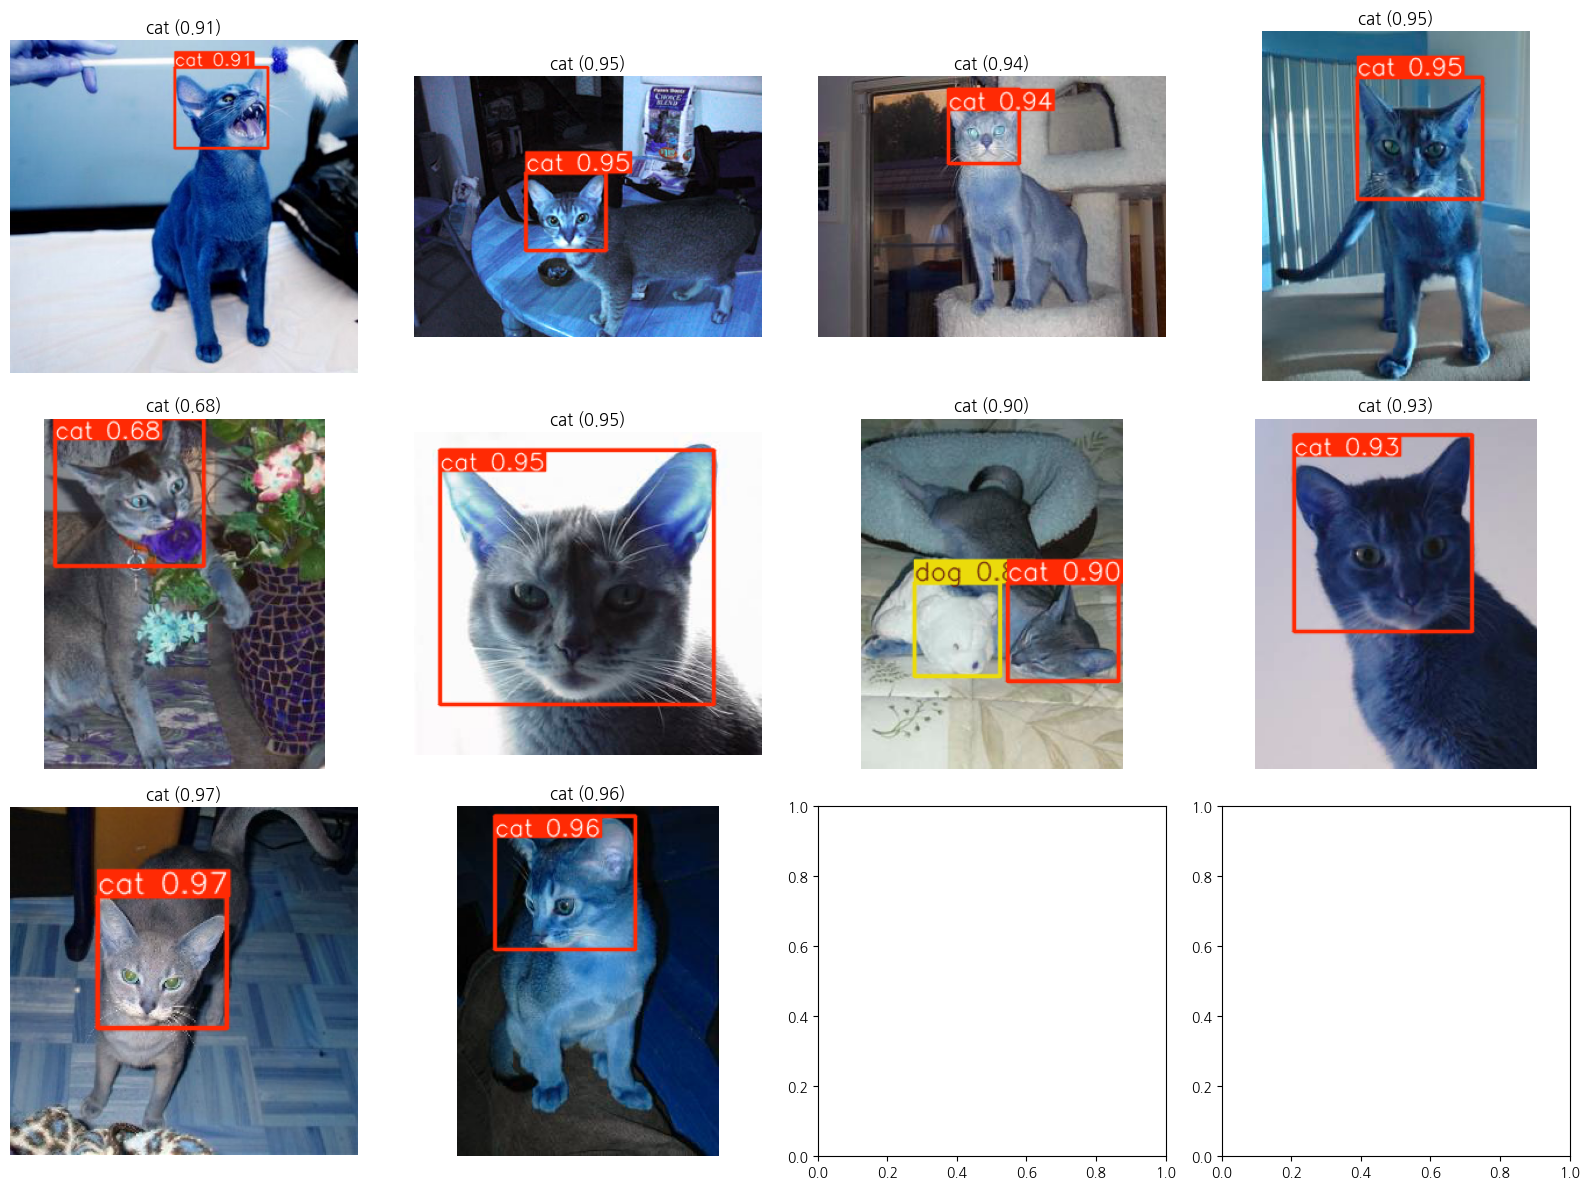

In [ ]:
from pathlib import Path

def test_on_samples(best_model):
    """테스트 이미지에서 샘플 예측"""
    test_dir = os.path.join(yolo_dataset_path, 'images', 'test')
    test_images = list(Path(test_dir).glob("*.jpg"))[:12]  # 처음 12개만

    if not test_images:
        print("테스트 이미지를 찾을 수 없습니다.")
        return

    print(f"\n=== {len(test_images)}개 테스트 이미지 예측 ===")

    # 예측 수행
    results = best_model(test_images)

    # 결과 시각화
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    class_names = ['cat', 'dog']

    for idx, (result, ax) in enumerate(zip(results, axes)):
        img = result.orig_img
        annotated = result.plot()
        ax.imshow(annotated)
        ax.axis('off')
        if len(result.boxes) > 0:
            conf = result.boxes.conf[0].item()
            cls = int(result.boxes.cls[0].item())
            pred_class = class_names[cls] if cls < len(class_names) else 'unknown'
            ax.set_title(f'{pred_class} ({conf:.2f})')
        else:
            ax.set_title('No Detection')

    plt.tight_layout()
    plt.show()

# 테스트 샘플 예측
test_on_samples(best_model)


                    성능 요약
📊 데이터셋 규모:
   - 훈련: 2,564개
   - 검증: 1,100개
   - 테스트: 3,659개
   - 총 클래스: 2개 (고양이/강아지)
   - 품종 수: 37개 (고양이 12개, 강아지 25개)

🎯 모델 성능:
   - mAP@0.5: 99.5%
   - mAP@0.5:0.95: 96.2%
   - Precision: 98.7%
   - Recall: 100.0%

💡 개선 방안:
   1. 에포크 수 증가 (100-200 epochs)
   2. 더 큰 모델 사용 (YOLOv8s, YOLOv8m)
   3. 데이터 증강 기법 적용
   4. 하이퍼파라미터 튜닝
   5. 앙상블 모델 적용

=== 훈련 데이터 클래스 분포 ===
고양이 객체 수: 5개
강아지 객체 수: 5개
총 객체 수: 10개


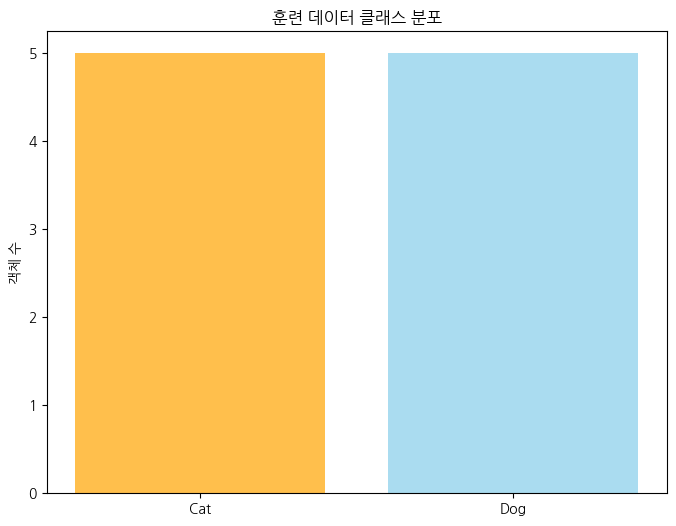


🎉 YOLO 테스트 완료!
더 자세한 결과는 'yolo_pet_detection/cat_dog_v1' 폴더를 확인하세요.


In [ ]:

# ============================================================================
# 7. 성능 요약 및 개선 방안
# ============================================================================

def performance_summary():
    """성능 요약 및 분석"""
    print("\n" + "="*60)
    print("                    성능 요약")
    print("="*60)

    # 데이터셋 정보
    print(f"📊 데이터셋 규모:")
    print(f"   - 훈련: 2,564개")
    print(f"   - 검증: 1,100개")
    print(f"   - 테스트: 3,659개")
    print(f"   - 총 클래스: 2개 (고양이/강아지)")
    print(f"   - 품종 수: 37개 (고양이 12개, 강아지 25개)")

    print(f"\n🎯 모델 성능:")
    if 'validation_results' in globals():
        print(f"   - mAP@0.5: {validation_results.box.map50:.1%}")
        print(f"   - mAP@0.5:0.95: {validation_results.box.map:.1%}")
        print(f"   - Precision: {validation_results.box.mp:.1%}")
        print(f"   - Recall: {validation_results.box.mr:.1%}")

    print(f"\n💡 개선 방안:")
    print("   1. 에포크 수 증가 (100-200 epochs)")
    print("   2. 더 큰 모델 사용 (YOLOv8s, YOLOv8m)")
    print("   3. 데이터 증강 기법 적용")
    print("   4. 하이퍼파라미터 튜닝")
    print("   5. 앙상블 모델 적용")

performance_summary()

# ============================================================================
# 8. 추가 분석 함수들
# ============================================================================

from pathlib import Path
def analyze_class_distribution():
    """클래스별 데이터 분포 분석"""
    train_label_dir = Path(os.path.join(yolo_dataset_path, 'labels', 'train'))

    cat_count = 0
    dog_count = 0

    for label_file in train_label_dir.glob("*.txt"):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id == 0:  # 고양이 (추정)
                    cat_count += 1
                elif class_id == 1:  # 강아지 (추정)
                    dog_count += 1

    print(f"\n=== 훈련 데이터 클래스 분포 ===")
    print(f"고양이 객체 수: {cat_count}개")
    print(f"강아지 객체 수: {dog_count}개")
    print(f"총 객체 수: {cat_count + dog_count}개")

    # 분포 시각화
    plt.figure(figsize=(8, 6))
    plt.bar(['Cat', 'Dog'], [cat_count, dog_count],
            color=['orange', 'skyblue'], alpha=0.7)
    plt.title('훈련 데이터 클래스 분포')
    plt.ylabel('객체 수')
    plt.show()

# 클래스 분포 분석 실행
analyze_class_distribution()

print("\n🎉 YOLO 테스트 완료!")
print("더 자세한 결과는 'yolo_pet_detection/cat_dog_v1' 폴더를 확인하세요.")

In [ ]:
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
ret, frame = cap.read()
cap.release()

if ret and frame is not None:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("카메라 프레임을 읽을 수 없습니다.")

In [ ]:
def yolo_live_cam_counter(yolo_best_model_path=yolo_best_model_path):
    model = YOLO(yolo_best_model_path)
    class_names = ['cat', 'dog']
    
    cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    detection_counts = {'cat': 0, 'dog': 0, 'none': 0}
    frame_count = 0
    
    print("탐지 카운터 모드 (ESC로 종료)")
    print("10초마다 결과를 요약해서 출력합니다.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        results = model(frame, verbose=False, conf=0.6)
        annotated_frame = results[0].plot()
        
        # 탐지 결과 카운트
        if len(results[0].boxes) > 0:
            cls = int(results[0].boxes.cls[0].item())
            detected_class = class_names[cls]
            detection_counts[detected_class] += 1
        else:
            detection_counts['none'] += 1
        
        frame_count += 1
        
        # 10초마다 (300프레임) 요약 출력
        if frame_count % 300 == 0:
            total = sum(detection_counts.values())
            print(f"\n=== {frame_count//30}초 경과 ===")
            print(f"고양이: {detection_counts['cat']}회 ({detection_counts['cat']/total*100:.1f}%)")
            print(f"강아지: {detection_counts['dog']}회 ({detection_counts['dog']/total*100:.1f}%)")
            print(f"미탐지: {detection_counts['none']}회 ({detection_counts['none']/total*100:.1f}%)")
        
        cv2.imshow('YOLO 카운터', annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    # 최종 결과
    print("\n=== 최종 결과 ===")
    total = sum(detection_counts.values())
    for class_name, count in detection_counts.items():
        print(f"{class_name}: {count}회 ({count/total*100:.1f}%)")

# 카운터 버전 실행
yolo_live_cam_counter()

탐지 카운터 모드 (ESC로 종료)
10초마다 결과를 요약해서 출력합니다.

=== 최종 결과 ===
cat: 0회 (0.0%)
dog: 2회 (3.4%)
none: 56회 (96.6%)


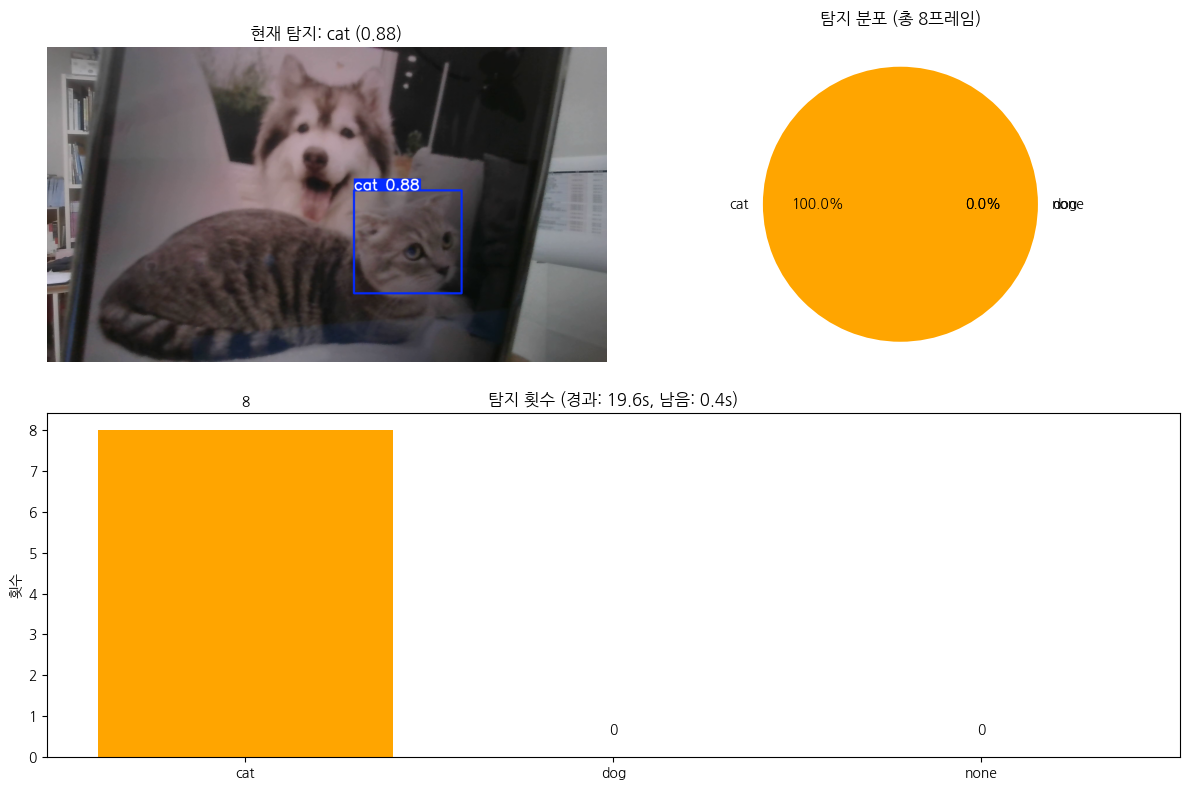

설정된 시간이 경과하여 자동 중단합니다.

=== 최종 결과 ===
cat: 8회 (100.0%)
dog: 0회 (0.0%)
none: 0회 (0.0%)


In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import time
from ultralytics import YOLO
import threading
import base64
from io import BytesIO

# 방법 1: 주기적 업데이트 방식
def yolo_live_cam_notebook(yolo_best_model_path=yolo_best_model_path, duration=30):
    """
    노트북에서 실시간 YOLO 탐지 (주기적 화면 갱신)
    duration: 실행 시간(초)
    """
    model = YOLO(yolo_best_model_path)
    class_names = ['cat', 'dog']
    
    cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    detection_counts = {'cat': 0, 'dog': 0, 'none': 0}
    start_time = time.time()
    frame_count = 0
    
    print(f"YOLO 실시간 탐지 시작 ({duration}초간 실행)")
    
    try:
        results = None
        while time.time() - start_time < duration:
            ret, frame = cap.read()
            if not ret:
                break
            
            # YOLO 탐지 (매 5프레임마다)
            if frame_count % 10 == 0:
                results = model(frame, verbose=False, conf=0.6)
                annotated_frame = results[0].plot()
                
                # 탐지 결과 카운트
                if len(results[0].boxes) > 0:
                    cls = int(results[0].boxes.cls[0].item())
                    detected_class = class_names[cls]
                    detection_counts[detected_class] += 1
                    conf = results[0].boxes.conf[0].item()
                    current_detection = f"{detected_class} ({conf:.2f})"
                else:
                    detection_counts['none'] += 1
                    current_detection = "미탐지"
                
                # 2초마다 화면 업데이트 (60프레임마다)
            if results is not None:
                if frame_count % 2 == 0:
                    clear_output(wait=True)
                    
                    # 현재 프레임 표시
                    plt.figure(figsize=(12, 8))
                    
                    plt.subplot(2, 2, 1)
                    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
                    plt.title(f'현재 탐지: {current_detection}')
                    plt.axis('off')
                    
                    # 통계 그래프
                    plt.subplot(2, 2, 2)
                    total = sum(detection_counts.values())
                    if total > 0:
                        labels = list(detection_counts.keys())
                        values = [detection_counts[k] for k in labels]
                        colors = ['orange', 'skyblue', 'lightgray']
                        
                        plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%')
                        plt.title(f'탐지 분포 (총 {total}프레임)')
                    
                    # 시간별 통계
                    plt.subplot(2, 1, 2)
                    elapsed = time.time() - start_time
                    remaining = duration - elapsed
                    
                    bars = plt.bar(labels, [detection_counts[k] for k in labels], color=colors)
                    plt.title(f'탐지 횟수 (경과: {elapsed:.1f}s, 남음: {remaining:.1f}s)')
                    plt.ylabel('횟수')
                    
                    # 값 표시
                    for bar, value in zip(bars, [detection_counts[k] for k in labels]):
                        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                               str(value), ha='center', va='bottom')
                    
                    plt.tight_layout()
                    plt.show()
            
            
            frame_count += 1
            # ESC 또는 q 키 입력 시 중단
            key = cv2.waitKey(1) & 0xFF
            if key == 27 or key == ord('q'):
                print("사용자 입력(q 또는 ESC)으로 중단합니다.")
                break
            # duration 초 경과 시 자동 중단
            if time.time() - start_time > duration:
                print("설정된 시간이 경과하여 자동 중단합니다.")
                break
            time.sleep(0.03)  # 약 30 FPS
            
    except KeyboardInterrupt:
        print("\n사용자에 의해 중단되었습니다.")
    finally:
        cap.release()
        
        # 최종 결과
        print(f"\n=== 최종 결과 ===")
        total = sum(detection_counts.values())
        for class_name, count in detection_counts.items():
            if total > 0:
                percentage = count/total*100
                print(f"{class_name}: {count}회 ({percentage:.1f}%)")

# 실행
yolo_live_cam_notebook(duration=20)  # 30초간 실행

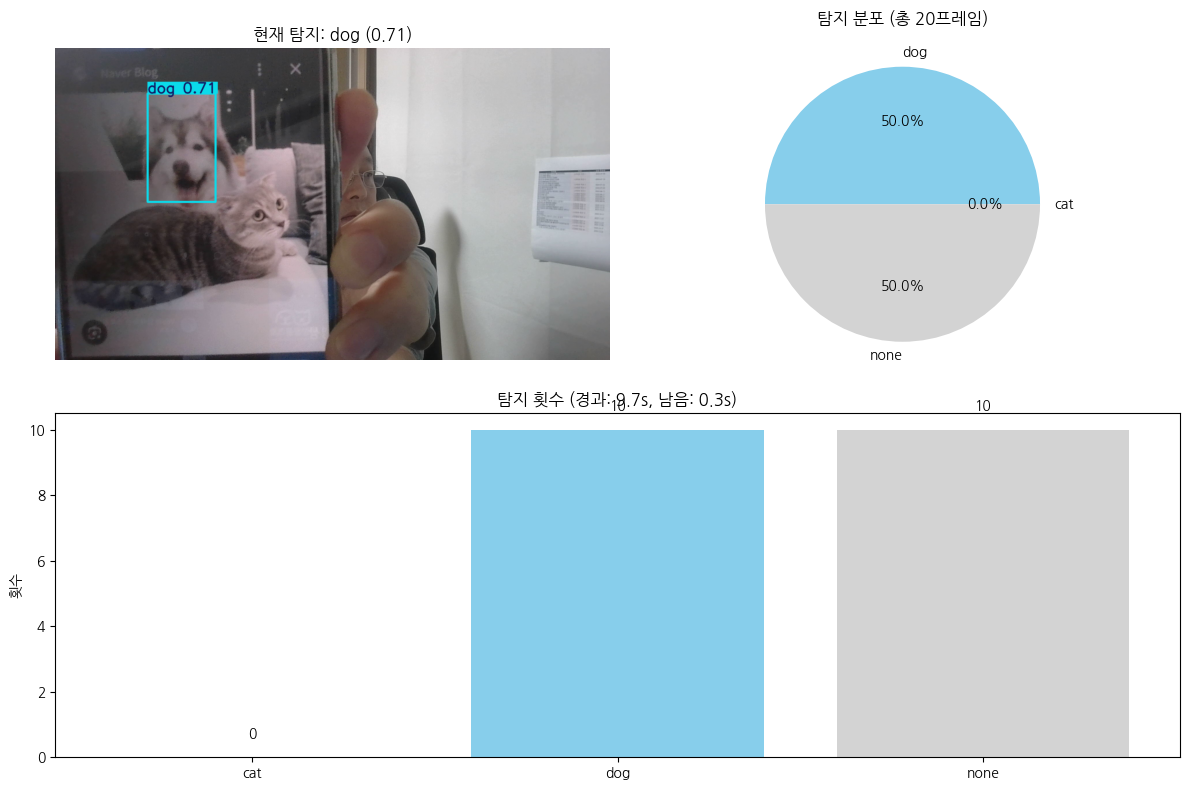

설정된 시간이 경과하여 자동 중단합니다.

=== 최종 결과 ===
cat: 0회 (0.0%)
dog: 10회 (50.0%)
none: 10회 (50.0%)


In [ ]:
yolo_live_cam_notebook(duration=10)

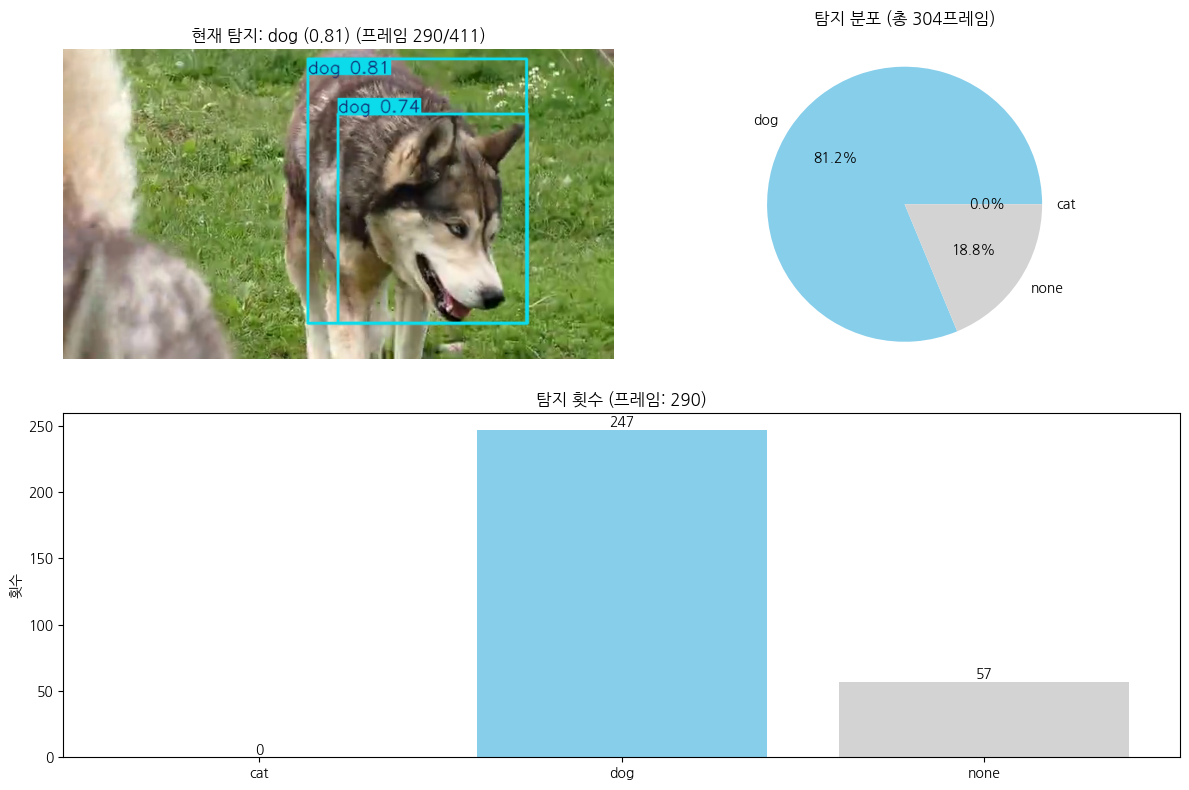

최대 프레임 수에 도달하여 중단합니다.

=== 최종 결과 ===
cat: 0회 (0.0%)
dog: 259회 (82.0%)
none: 57회 (18.0%)


In [16]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from ultralytics import YOLO

def yolo_mp4_notebook(mp4_path, yolo_best_model_path=yolo_best_model_path, max_frames=500):
    """
    mp4 동영상에서 YOLO 탐지 결과를 노트북에서 시각화
    mp4_path: 동영상 파일 경로
    max_frames: 최대 처리 프레임 수 (None이면 전체)
    """
    model = YOLO(yolo_best_model_path)
    class_names = ['cat', 'dog']
    
    cap = cv2.VideoCapture(mp4_path)
    if not cap.isOpened():
        print(f"동영상 파일을 열 수 없습니다: {mp4_path}")
        return
    
    detection_counts = {'cat': 0, 'dog': 0, 'none': 0}
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"YOLO mp4 탐지 시작 (총 {total_frames}프레임, 최대 {max_frames if max_frames else total_frames}프레임)")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("동영상 프레임을 더 이상 읽을 수 없습니다.")
                break
            
            results = model(frame, verbose=False, conf=0.6)
            annotated_frame = results[0].plot()
            
            # 탐지 결과 카운트
            if len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    cls = int(box.cls.item())
                    detected_class = class_names[cls]
                    detection_counts[detected_class] += 1
                conf = results[0].boxes.conf[0].item()
                current_detection = f"{detected_class} ({conf:.2f})"
            else:
                detection_counts['none'] += 1
                current_detection = "미탐지"
            
            # 10프레임마다 화면 업데이트
            if frame_count % 10 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(12, 8))
                plt.subplot(2, 2, 1)
                plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'현재 탐지: {current_detection} (프레임 {frame_count}/{total_frames})')
                plt.axis('off')
                
                # 통계 그래프
                plt.subplot(2, 2, 2)
                total = sum(detection_counts.values())
                labels = list(detection_counts.keys())
                values = [detection_counts[k] for k in labels]
                colors = ['orange', 'skyblue', 'lightgray']
                if total > 0:
                    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%')
                    plt.title(f'탐지 분포 (총 {total}프레임)')
                
                # 시간별 통계
                plt.subplot(2, 1, 2)
                bars = plt.bar(labels, values, color=colors)
                plt.title(f'탐지 횟수 (프레임: {frame_count})')
                plt.ylabel('횟수')
                for bar, value in zip(bars, values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                             str(value), ha='center', va='bottom')
                plt.tight_layout()
                plt.show()
            
            frame_count += 1
            if max_frames and frame_count >= max_frames:
                print("최대 프레임 수에 도달하여 중단합니다.")
                break
            
            time.sleep(0.01)  # 너무 빠른 처리 방지
            
    except KeyboardInterrupt:
        print("\n사용자에 의해 중단되었습니다.")
    finally:
        cap.release()
        print(f"\n=== 최종 결과 ===")
        total = sum(detection_counts.values())
        for class_name, count in detection_counts.items():
            if total > 0:
                percentage = count/total*100
                print(f"{class_name}: {count}회 ({percentage:.1f}%)")

# 사용 예시
mp4_path = r"dog.mp4"
yolo_mp4_notebook(mp4_path, max_frames=300)